In [93]:
#IMPORT BIBLIOTEKA

%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = dilate(dilate(erode(invert(binary_image))))
    return ret_val


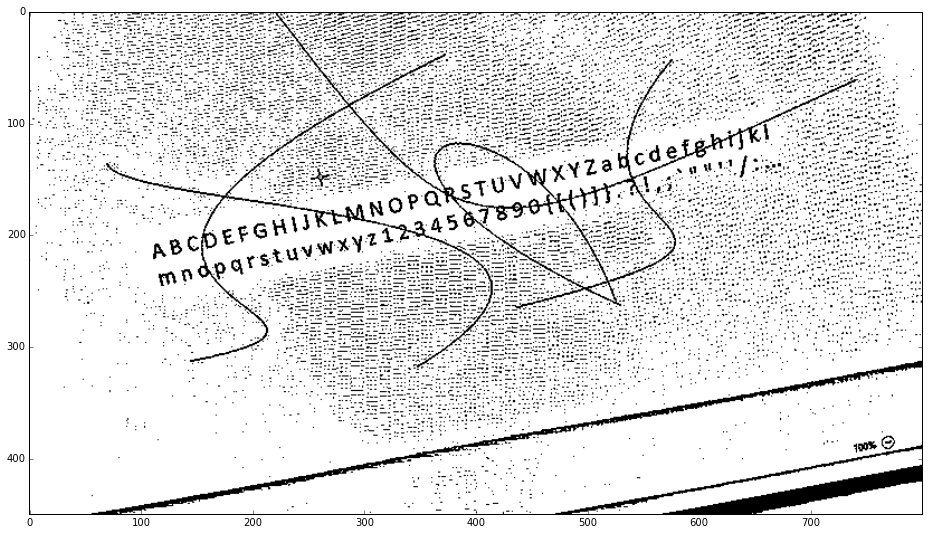

In [102]:
# učitavanje digitalne slike
image_color = load_image('test.jpg')
# formiranje binarne slike
img_bin = image_bin_adaptive(image_gray(image_color))

img = 

display_image(img)

In [95]:
def rotate_regions(contours,angles,centers,sizes,rotate):
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            if rotate:
                rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
                ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            else:
                rx = x
                ry = y
            
            region_points[i] = [rx,ry]
        ret_val.append(region_points)
        

    return ret_val

In [96]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=28 * 28, activation='sigmoid'))
    ann.add(Dense(8, activation='sigmoid'))
    #ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    #ann.add(Dense(input_dim=128, output_dim=10,init="glorot_uniform"))
    #ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [97]:
def select_roi(image_orig, image_bin, rotate=False):
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
            
        region_points = []
        for i in range (xt,xt+w):
            for j in range(yt,yt+h):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes,rotate)
    
    regions_dict = {}
    #punimo y tacke radi klasterovanja po y osi(da ti pojasnim)
    ya = []
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])
        
        
        cv2.rectangle(image_orig,(min_x,min_y),(min_x+(max_x-min_x),min_y+(max_y-min_y)),(255,0,0),2)
        
        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
            region[y-min_y,x-min_x] = 255

        ya.append(min_y)
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
   
    
    
    
    return image_orig, sorted_regions[:, 0], region_distances , ya

In [98]:
def display_result(results,alphabet,k_means,k_means1):
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    w_space_group1 = max(enumerate(k_means1.cluster_centers_), key = lambda x: x[1])[0]
    result = []
    result = []
    notes_sum = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group and k_means1.labels_[idx] == w_space_group1):
            result.append(1 - notes_sum)
            notes_sum = 0
        
        notes_sum += alphabet[winner(output)]

    if notes_sum > 0:
        result.append(notes_sum)
    return result

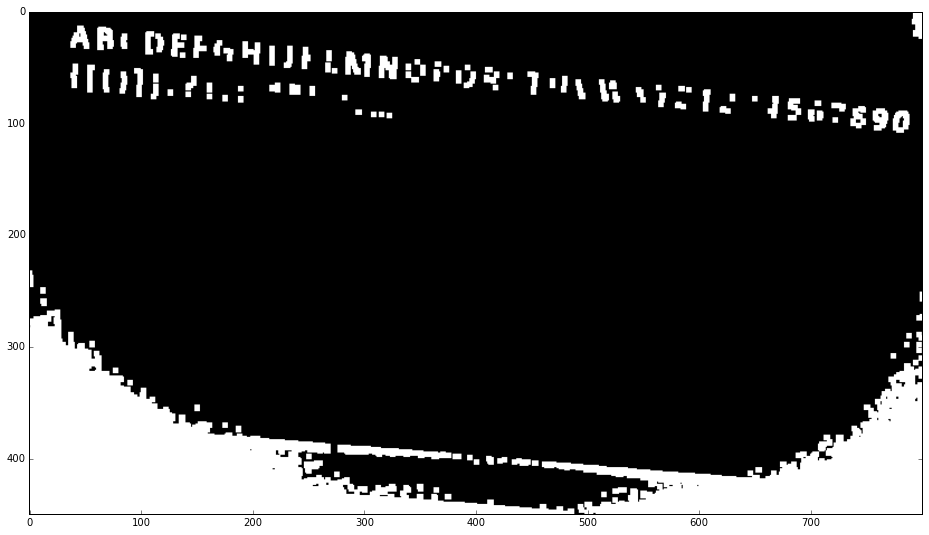

In [99]:
img_train = load_image('test.jpg')
img_train_bin = remove_noise(image_bin(image_gray(img_train)))
display_image(img_train_bin)

107


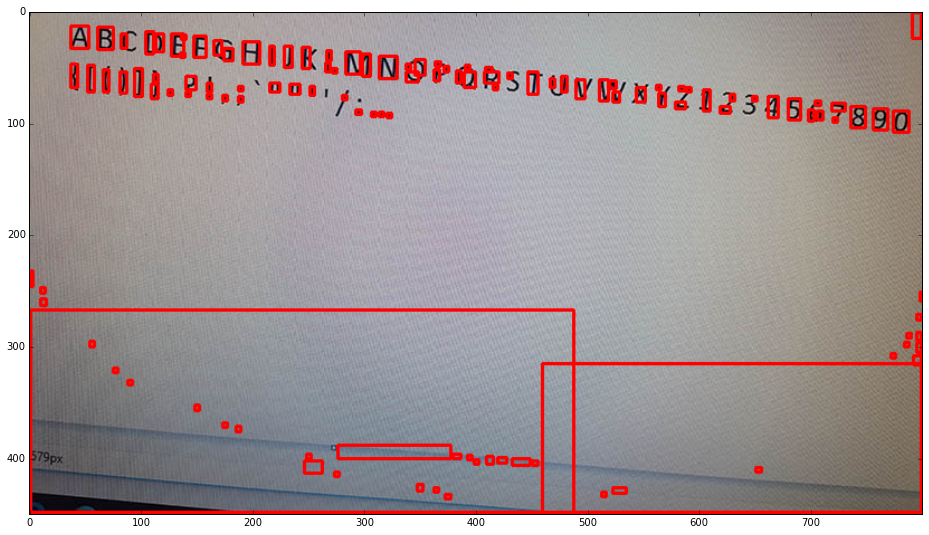

In [100]:
img, selected_regions, distances, y = select_roi(img_train, img_train_bin)
print len(selected_regions)
display_image(img)

IndexError: index 8 is out of bounds for axis 0 with size 8

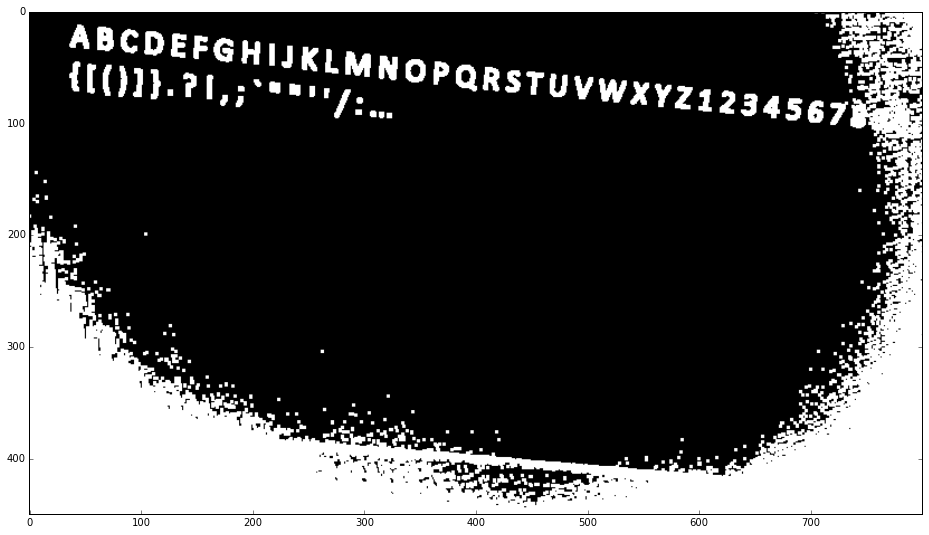

In [101]:
img_train = load_image('test.jpg')
img_train_bin = dilate(invert(image_bin(image_gray(img_train))))
sel_img_train, shapes, distances, y = select_roi(img_train.copy(), img_train_bin)
display_image(img_train_bin)
inputs = prepare_for_ann(shapes)
alphabet = [1./8,1./16,1./4,1./2,1./2,1./4,1./8,1./16]
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)
results = ann.predict(np.array(inputs, np.float32))
for note in results:
    print alphabet[winner(note)]

In [ ]:
img_test = load_image('primer4_test.png')
img_test_bin = (remove_noise(image_bin(image_gray(img_test))))
all_distances = []
#display_image(img_test_bin[:][:250])
sel_img_test, shapes, distances, y = select_roi(img_test.copy(), img_test_bin)

#display_image(sel_img_test)
inputs = prepare_for_ann(shapes)
results = ann.predict(np.array(inputs, np.float32))

distances = np.array(distances).reshape(len(distances), 1)
k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(distances)

y = np.array(y).reshape(len(y), 1)
k_means1 = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means1.fit(y)

print display_result(results,alphabet,k_means,k_means1)
display_image(img_test_bin)
